# Project: Investigate a Dataset (TMDb Movie Data)

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction
For this project I have chosen to analyse movie data from TMDb ([The Movie Database](https://www.themoviedb.org)) for over 10,000 movies aggregated by [Kaggle](https://www.kaggle.com). The data contains information such as genre, cast, budget, revenue, popularity, rating etc. 

_These are the question I want to explore:_

1. What are the most popular genres over the years?
2. What are the characteristics of movies with highest revenues?
    * Budget
    * Cast
    * Month released
    * Day of the week of release
    * Popularity

### Environment Setup

In [46]:
## import statements
import unicodecsv
from pprint import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## magics
%matplotlib inline

## initializations
sns.set_style('darkgrid')
tmdb_csv_file = 'tmdb-movies.csv'

<a id='wrangling'></a>
## Data Wrangling

### General Properties

Let's take a look at some of the rows in the data:

In [3]:
# Load your data and print out a few lines. Perform operations to inspect data
#   types and look for instances of missing or possibly errant data.

## read csv file:
initial_df = pd.read_csv(tmdb_csv_file)
                         
## print first five rows in data:
initial_df.head()

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08
2,262500,tt2908446,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/15,2480,6.3,2015,1.012000e+08,2.716190e+08
3,140607,tt2488496,11.173104,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,http://www.starwars.com/films/star-wars-episod...,J.J. Abrams,Every generation has a story.,...,Thirty years after defeating the Galactic Empi...,136,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,12/15/15,5292,7.5,2015,1.839999e+08,1.902723e+09
4,168259,tt2820852,9.335014,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,http://www.furious7.com/,James Wan,Vengeance Hits Home,...,Deckard Shaw seeks revenge against Dominic Tor...,137,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,4/1/15,2947,7.3,2015,1.747999e+08,1.385749e+09


Comments:
* The data contains __imdb_id__ as well as __id__ from TMDb. This is may have been provided to correlate data from both databases.
* The __budget__ and __revenue__ columns are not of much use as it will be more appropriate to use the adjusted values, __budget_adj__ and __revenue_adj__ to compare movies from different time periods.
* No units for the budget and revenue are provided. I'll assume them to be dollars.

Now I want to know some basic info about the data:

In [8]:
## describe the table:
initial_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
id                      10866 non-null int64
imdb_id                 10856 non-null object
popularity              10866 non-null float64
budget                  10866 non-null int64
revenue                 10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
homepage                2936 non-null object
director                10822 non-null object
tagline                 8042 non-null object
keywords                9373 non-null object
overview                10862 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj              1

Pertaining to my first question, the genre column of 223 rows seems to be NULL. These rows will have to be removed in the data wrangling part.

In [9]:
## number of rows:
len(initial_df)

10866

In [5]:
## range of years from which movies are included:

release_years = initial_df['release_year']
print(int(release_years.min()),'-',int(release_years.max()))

1960 - 2015


In [36]:
## Highest revenue movie:

# It will be nice to have a function that prints info about a movie with a particular id:

def describe_movie(tmdb_id, df):
    '''
        Displays info about a movie with a particular TMDb ID.
    '''
    # first let's get the row for this id:
    movie_df_intermediate = df[df['id'] == tmdb_id]
    # ^ this is still a dataframe... we need to convert this to a series:
    movie_row = pd.Series(movie_df_intermediate.iloc[0])
    
    # now printing relevant info:
    print('{}({}):'.format(movie_row['original_title'], movie_row[ 'release_year']))
    print('\tBudget (Adjusted): {}$'.format(movie_row['budget_adj']))
    print('\tRevenue (Adjusted): {}$'.format(movie_row['revenue_adj']))
    print('\tDirector: {}'.format(movie_row['director'])) 
    print('\tGenres: {}'.format(', '.join(movie_row['genres'].split('|'))))
    print('\tCast: {}'.format(', '.join(movie_row['cast'].split('|'))))
    print('\tAverage Rating:', movie_row['vote_average'])
    print('\tPopularity:', movie_row['popularity'])
    
    
max_revenue_idx = initial_df['revenue_adj'].idxmax()
max_revenue_tmdb_id = initial_df.loc[max_revenue_idx, 'id']
describe_movie(max_revenue_tmdb_id, initial_df)


Avatar(2009):
	Budget (Adjusted): 240886902.887613$
	Revenue (Adjusted): 2827123750.41189$
	Director: James Cameron
	Genres: Action, Adventure, Fantasy, Science Fiction
	Cast: Sam Worthington, Zoe Saldana, Sigourney Weaver, Stephen Lang, Michelle Rodriguez
	Average Rating: 7.1
	Popularity: 9.432768


In [37]:
## Highest budget movie:

max_budget_idx = initial_df['budget_adj'].idxmax()
max_budget_tmdb_id = initial_df.loc[max_budget_idx, 'id']
describe_movie(max_budget_tmdb_id, initial_df)

The Warrior's Way(2010):
	Budget (Adjusted): 425000000.0$
	Revenue (Adjusted): 11087569.0$
	Director: Sngmoo Lee
	Genres: Adventure, Fantasy, Action, Western, Thriller
	Cast: Kate Bosworth, Jang Dong-gun, Geoffrey Rush, Danny Huston, Ti Lung
	Average Rating: 6.4
	Popularity: 0.25054


In [38]:
## Highest rated movie:

max_rating_idx = initial_df['vote_average'].idxmax()
max_rating_tmdb_id = initial_df.loc[max_rating_idx, 'id']
describe_movie(max_rating_tmdb_id, initial_df)

The Story of Film: An Odyssey(2011):
	Budget (Adjusted): 0.0$
	Revenue (Adjusted): 0.0$
	Director: Mark Cousins
	Genres: Documentary
	Cast: Mark Cousins, Jean-Michel Frodon, Cari Beauchamp, Agnes de Mille
	Average Rating: 9.2
	Popularity: 0.006925


The budget and revenue data for this movie seems to be unavailable.

In [39]:
## Most popular movie:

max_popularity_idx = initial_df['popularity'].idxmax()
max_popularity_tmdb_id = initial_df.loc[max_popularity_idx, 'id']
describe_movie(max_popularity_tmdb_id, initial_df)

Jurassic World(2015):
	Budget (Adjusted): 137999939.280026$
	Revenue (Adjusted): 1392445892.5238$
	Director: Colin Trevorrow
	Genres: Action, Adventure, Science Fiction, Thriller
	Cast: Chris Pratt, Bryce Dallas Howard, Irrfan Khan, Vincent D'Onofrio, Nick Robinson
	Average Rating: 6.5
	Popularity: 32.985763


### Trends In Budgets And Revenues

#### Statistcs

In [34]:
## budget statistics (adjusted):

budgets_adj = initial_df['budget_adj']
budgets_adj.describe()

count    1.086600e+04
mean     1.755104e+07
std      3.430616e+07
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.085325e+07
max      4.250000e+08
Name: budget_adj, dtype: float64

In [36]:
## revenue statistics (adjusted):

revenues_adj = initial_df['revenue_adj']
revenues_adj.describe()

count    1.086600e+04
mean     5.136436e+07
std      1.446325e+08
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      3.369710e+07
max      2.827124e+09
Name: revenue_adj, dtype: float64

#### Plots

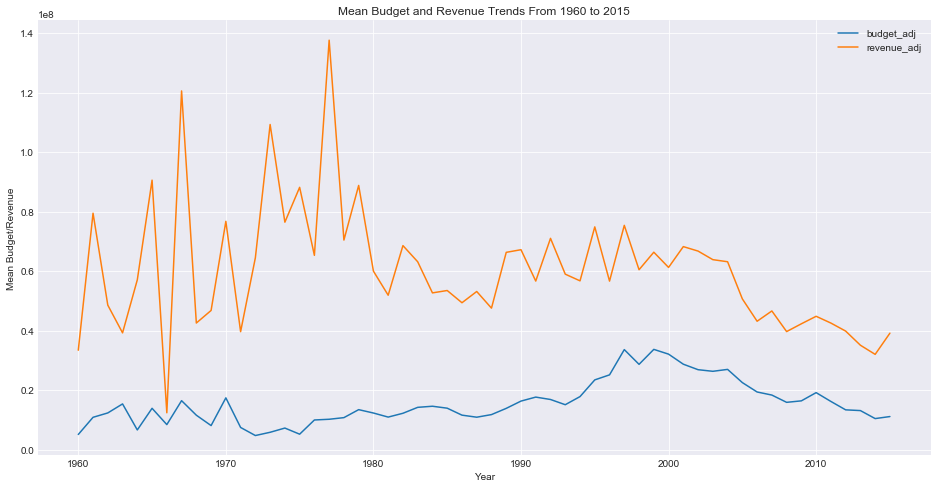

In [50]:
## year-wise trends in mean budgets and reveneus:

# extract mean data:
budgets_grouped_by_year = initial_df.groupby('release_year', as_index=False)['budget_adj']
revenues_grouped_by_year = initial_df.groupby('release_year', as_index=False)['revenue_adj']

yearly_budget_means = budgets_grouped_by_year.mean()
yearly_revenue_means = revenues_grouped_by_year.mean()

# now plotting:
fig = plt.figure(figsize = (16, 8))
ax = plt.axes()
ax.plot(yearly_budget_means['release_year'], yearly_budget_means['budget_adj'])
ax.plot(yearly_revenue_means['release_year'], yearly_revenue_means['revenue_adj'])
plt.xlabel('Year')
plt.ylabel('Mean Budget/Revenue')
plt.title('Mean Budget and Revenue Trends From 1960 to 2015')
plt.legend()
plt.show()

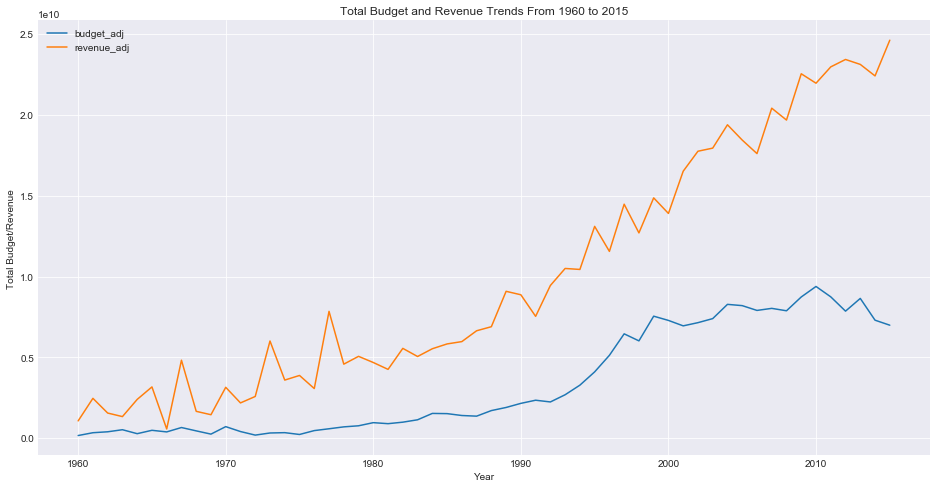

In [54]:
## year-wise trends in total budgets and reveneus for all movies:

# extract sums:
yearly_budget_sums = budgets_grouped_by_year.sum()
yearly_revenue_sums = revenues_grouped_by_year.sum()

# now plotting:
fig = plt.figure(figsize = (16, 8))
ax = plt.axes()
ax.plot(yearly_budget_sums['release_year'], yearly_budget_sums['budget_adj'])
ax.plot(yearly_revenue_sums['release_year'], yearly_revenue_sums['revenue_adj'])
plt.xlabel('Year')
plt.ylabel('Total Budget/Revenue')
plt.title('Total Budget and Revenue Trends From 1960 to 2015')
plt.legend()
plt.show()

### Problems With Dataset
While inspecting the data, I noticed the following problems which need to be addressed:
* The __budget_adj__ and __revenue_adj__ columns have 0 value in many rows.
* The __budget__ and __revenue__ columns are unadjusted and thus not useful for the analysis. Also, the __imdb_id__ column is redundant as I will use the TMDb IDs. These columns should be removed.
* The __release_date__ column is stored as a string. The dates need to be converted to datetime objects.
* The columns __production_companies__, __cast__ and __genres__ should be converted to list/tuples for convenience.

Let's check for duplicate rows in the data:

In [57]:
# select rows which have been duplicated:
initial_df[initial_df.duplicated() == True]

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
2090,42194,tt0411951,0.59643,30000000,967000,TEKKEN,Jon Foo|Kelly Overton|Cary-Hiroyuki Tagawa|Ian...,NaN,Dwight H. Little,Survival is no game,...,"In the year of 2039, after World Wars destroy ...",92,Crime|Drama|Action|Thriller|Science Fiction,Namco|Light Song Films,3/20/10,110,5.0,2010,30000000.0,967000.0


Only one row has been duplicated. I will clean this up in the next section.

### Data Cleaning

#### Removing useless columns
First I'll remove the following columns as I do not need them in my analysis:
* budget
* revenue
* imdb_id
* homepage
* overview
* tagline
* vote count
* keywords

In [104]:
# using drop() function to drop useless columns:

useless_columns = ['budget', 'revenue', 'imdb_id', 'homepage', 'overview', 'tagline', 'vote_count', 'keywords']
cleaned_df = initial_df.drop(useless_columns, axis=1) # axis = 1 means columns (0 for rows)

cleaned_df.head(2)

,id,popularity,original_title,cast,director,runtime,genres,production_companies,release_date,vote_average,release_year,budget_adj,revenue_adj
0,135397,32.985763,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Colin Trevorrow,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,6.5,2015,1.379999e+08,1.392446e+09
1,76341,28.419936,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,George Miller,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,7.1,2015,1.379999e+08,3.481613e+08


#### Removing the duplicate rows

In [105]:
# drop_duplicates() drops all duplicate rows
cleaned_df.drop_duplicates(inplace=True)

#### Handling null values
Let's replace 0s in budget and revenue columns with NaNs:

In [106]:
# replacing values 0s with NaNs:
cleaned_df.loc[cleaned_df['revenue_adj'] < 10, 'revenue_adj'] = np.nan
cleaned_df.loc[cleaned_df['budget_adj'] < 10, 'budget_adj'] = np.nan

cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10865 entries, 0 to 10865
Data columns (total 13 columns):
id                      10865 non-null int64
popularity              10865 non-null float64
original_title          10865 non-null object
cast                    10789 non-null object
director                10821 non-null object
runtime                 10865 non-null int64
genres                  10842 non-null object
production_companies    9835 non-null object
release_date            10865 non-null object
vote_average            10865 non-null float64
release_year            10865 non-null int64
budget_adj              5155 non-null float64
revenue_adj             4841 non-null float64
dtypes: float64(4), int64(3), object(6)
memory usage: 1.2+ MB


The non-null counts for __budget_adj__ and __revenue_adj__ have been reduced by almost half!

#### Correcting Data Types

First, let's convert __release_year__ column to datetime objects:

In [107]:
# I will use the to_datetime function provied in pandas:
cleaned_df['release_date'] = pd.to_datetime(cleaned_df['release_date'])

# checking:
cleaned_df.loc[100, 'release_date'].year

2015

Now converting __production_companies__, __cast__ and __genres__ to lists:

In [108]:
def string_to_list(string):
    '''
        Returns a list of strings obtained by splitting the input string.
        If input is not a string, returns NaN.
    '''
    if isinstance(string, str):
        return string.split('|')
    return np.nan

cleaned_df['genres'] = cleaned_df['genres'].apply(string_to_list)
cleaned_df['production_companies'] = cleaned_df['production_companies'].apply(string_to_list)
cleaned_df['cast'] = cleaned_df['cast'].apply(string_to_list)

# checking:
cleaned_df.loc[100, 'genres']

['Adventure', 'Animation', 'Family']

#### More considerations

_For my question regarding genre popularities_, I will need a separate dataframe from which rows without genre information are dropped.

_For my question regarding characteristcs of high-revenue movies_, I will drop rows that are missing the budget or revenue information.

In [109]:
# create dataset for genre popularity analysis by eliminating rows without genre information:
genres_df = cleaned_df.dropna(subset=['genres'])
print('Movies with genres available:', len(genres_df))

# create dataset for second question about high-revenue movies
# drop rows without budget or revenue information:

revenue_df = cleaned_df.dropna(subset=['revenue_adj', 'budget_adj'], how='any')
print('Movies with both revenue and budget info:', len(revenue_df))
revenue_df.head()

Movies with genres available: 10842
Movies with both revenue and budget info: 3840


,id,popularity,original_title,cast,director,runtime,genres,production_companies,release_date,vote_average,release_year,budget_adj,revenue_adj
0,135397,32.985763,Jurassic World,"[Chris Pratt, Bryce Dallas Howard, Irrfan Khan...",Colin Trevorrow,124,"[Action, Adventure, Science Fiction, Thriller]","[Universal Studios, Amblin Entertainment, Lege...",2015-06-09,6.5,2015,1.379999e+08,1.392446e+09
1,76341,28.419936,Mad Max: Fury Road,"[Tom Hardy, Charlize Theron, Hugh Keays-Byrne,...",George Miller,120,"[Action, Adventure, Science Fiction, Thriller]","[Village Roadshow Pictures, Kennedy Miller Pro...",2015-05-13,7.1,2015,1.379999e+08,3.481613e+08
2,262500,13.112507,Insurgent,"[Shailene Woodley, Theo James, Kate Winslet, A...",Robert Schwentke,119,"[Adventure, Science Fiction, Thriller]","[Summit Entertainment, Mandeville Films, Red W...",2015-03-18,6.3,2015,1.012000e+08,2.716190e+08
3,140607,11.173104,Star Wars: The Force Awakens,"[Harrison Ford, Mark Hamill, Carrie Fisher, Ad...",J.J. Abrams,136,"[Action, Adventure, Science Fiction, Fantasy]","[Lucasfilm, Truenorth Productions, Bad Robot]",2015-12-15,7.5,2015,1.839999e+08,1.902723e+09
4,168259,9.335014,Furious 7,"[Vin Diesel, Paul Walker, Jason Statham, Miche...",James Wan,137,"[Action, Crime, Thriller]","[Universal Pictures, Original Film, Media Righ...",2015-04-01,7.3,2015,1.747999e+08,1.385749e+09


<a id='eda'></a>
## Exploratory Data Analysis

> **Tip**: Now that you've trimmed and cleaned your data, you're ready to move on to exploration. Compute statistics and create visualizations with the goal of addressing the research questions that you posed in the Introduction section. It is recommended that you be systematic with your approach. Look at one variable at a time, and then follow it up by looking at relationships between variables.

### Research Question 1 (Replace this header name!)

In [ ]:
# Use this, and more code cells, to explore your data. Don't forget to add
#   Markdown cells to document your observations and findings.


### Research Question 2  (Replace this header name!)

In [ ]:
# Continue to explore the data to address your additional research
#   questions. Add more headers as needed if you have more questions to
#   investigate.


<a id='conclusions'></a>
## Conclusions

> **Tip**: Finally, summarize your findings and the results that have been performed. Make sure that you are clear with regards to the limitations of your exploration. If you haven't done any statistical tests, do not imply any statistical conclusions. And make sure you avoid implying causation from correlation!

> **Tip**: Once you are satisfied with your work, you should save a copy of the report in HTML or PDF form via the **File** > **Download as** submenu. Before exporting your report, check over it to make sure that the flow of the report is complete. You should probably remove all of the "Tip" quotes like this one so that the presentation is as tidy as possible. Congratulations!